In [33]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import skew
import glob


In [2]:
proj_dir="/master/nplatt/schisto_aim_panel"
results_dir=f"{proj_dir}/results"

In [3]:
#you can get this table from the SCAN dryad link
info_df=pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",", header=0)
info_df

,Library ID,Museum Accession Number (NHM) or Donor ID,Predicted Species,Mitchondrial Haplotype,Population Assignment,NCBI SRA Accession,Project Citation,Country,Locality,Latitude,...,Original life-cycle stage collected,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments
0,angola_cota_57,MCF03050E0612,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907442,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,76.6,32.96,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
1,angola_cota_58,MCF03050E0613,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907441,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,71.6,32.83,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
2,angola_cota_59,MCF03050E0614,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907440,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,66.5,25.61,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
3,angola_icau_60,MCF03050E0615,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907439,Herein,Angola,Icau Wando village,-8.6451,...,miracidia,miracidia,56.7,25.73,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
4,angola_icau_61,MCF03050E0615,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907438,Herein,Angola,Icau Wando village,-8.6451,...,miracidia,miracidia,75.3,30.40,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,margrebowiei_zambia_ERR310940,"NHM3239,40",S. margrebowiei,Na,Na,ERR310940,Coghlan et al. (2018),Zambia,Lochinvar,Na,...,miracidia,adult worm (lab),152.2,33.72,True,NaN,Na,SCAN,SCAN,Data generated as part of the 50 Helminth Geno...
210,zambia_kafue_69,MCF03050E0836,S. haematobium,Na,Na,SRR11907433,Herein,Zambia,Kafue,-15.783442,...,miracidia,miracidia,93.9,9.25,False,NaN,Na,SCAN,CONTRAST,NaN
211,zambia_kafue_71,MCF03050E0843,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907431,Herein,Zambia,Kafue,-15.783442,...,cercariae,cercariae,88.5,43.49,True,NaN,100.00%,SCAN,CONTRAST,NaN
212,zambia_lishiko_66,MCF03050E0808,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907434,Herein,Zambia,Lishiko school,-15.74499,...,miracidia,miracidia,74.6,12.63,True,NaN,100.00%,SCAN,CONTRAST,NaN


# Prep Raw Data

In [5]:
os.chdir(f"{proj_dir}/data")

In [6]:
wget https://datadryad.org/downloads/file_stream/3964907

## Filter the VCF file

In [30]:
Path(f"{results_dir}/prep_vcf").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/prep_vcf")

In [15]:
info_df.columns

Index(['Library ID', 'Museum Accession Number (NHM) or Donor ID',
       'Predicted Species', 'Mitchondrial Haplotype', 'Population Assignment',
       'NCBI SRA Accession', 'Project Citation', 'Country', 'Locality',
       'Latitude', 'Longitude', 'Collection Date', 'Collection Host',
       'Original life-cycle stage collected', 'Life-cycle stage sequenced ',
       'Num Read Pairs (1e6)', 'Coverage', 'Final SNV Dataset',
       'Discordant COX1/ITS', '% S. haematobium ancestry (q)', 'Origin',
       'Project (Collector)', 'Comments'],
      dtype='object')

In [246]:
#which samples to exclude
info_df.loc[info_df["Final SNV Dataset"] == True]["Library ID"].to_csv("samples.include.list", sep=",", header=False, index=False)
!cat samples.include.list | wc -l

163


In [14]:
info_df.loc[info_df["Final SNV Dataset"] == True, "Predicted Species"].value_counts()

Predicted Species
S. haematobium     141
S. bovis            21
S. margrebowiei      1
Name: count, dtype: int64

In [16]:
info_df.loc[info_df["Final SNV Dataset"] == True, "Population Assignment"].value_counts()

Population Assignment
S. haematobium (northern)    82
S. haematobium (southern)    59
S. bovis                     21
Na                            1
Name: count, dtype: int64

In [ ]:
conda run -n popgen --cwd . --live-stream\
    vcftools \
        --gzvcf ../../data/scan_snvs.vcf.gz \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \

In [ ]:
conda run -n popgen --cwd . --live-stream\
    vcftools \
        --gzvcf ../../data/scan_snvs.vcf.gz \
        --maf 0.05 \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \

In [9]:
%%bash

conda run -n popgen --cwd . --live-stream\
    vcftools \
        --gzvcf ../../data/scan_snvs.vcf.gz \
        --maf 0.05 \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \
        --keep samples.include.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >autosomes_maf05.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
/../data/scan_snvs.vcf.gz
	--chr NC_067196.1
	--chr NC_067197.1
	--chr NC_067198.1
1--chr NC_067199.
	--chr NC_067200.1
	--chr NC_067201.1
	--chr NC_067202.1
	--keep samples.include.list
FO-allode-IN
	--maf 0.05
	--recode
	--stdout

Using zlib version: 1.3.1
ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the sa

In [10]:
%%bash

conda run -n popgen --live-stream \
    plink2 \
        --vcf autosomes_maf05.vcf \
        --allow-extra-chr \
        --double-id \
        --indep-pairwise 25 5 0.20 \
        --out ld

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
urcell, Christopher Chang   GNU General Public License v3
Logging to ld.log.
Options in effect:
allow-extra-chr
  --double-id
  --indep-pairwise 25 5 0.20
  --out ld
  --vcf autosomes_maf05.vcf

tart time: Thu Mar  6 17:53:57 2025
iB for main RAM detected, ~1017340 available; reserving 515643 M
workspace.
Using up to 192 threads (change this with --threads).
--vcf: 5972982 variants scanned.
--vcf: ld-temporary.pgen + ld-temporary.pvar.zst + ld-temporary.psam written.
s, 0 males, 163 ambiguous; 163 founders) loaded from
ld-temporary.psam.
 ld-temporary.pvar.zst. from
Note: No phenotype data present.
done.lating allele frequencies... 0%
5591481/5972982 variants removed.ds): 0%
Variant lists written to ld.prune.in and ld.prune.out .
End time: Thu Mar  6 17:54:58 2025


In [ ]:
%%bash

conda run -n vcftools --live-stream \
    vcftools \
        --vcf scan_autosomes_maf05_ld_w_smarg.vcf \
        --exclude ld.prune.out \
        --recode \
        --recode-INFO-all \
        --stdout \
        >scan_autosomes_maf05_ld_w_smarg.vcf

echo "snv_id" >all_snvs.list; grep -v "#" scan_autosomes_maf05_ld.vcf | cut -f3 >>all_snvs.list

In [247]:
%%bash

conda run -n vcftools --live-stream \
    vcftools \
        --vcf scan_autosomes_maf05_ld_w_smarg.vcf \
        --remove-indv margrebowiei_zambia_ERR310940 \
        --recode \
        --recode-INFO-all \
        --stdout \
        >scan_autosomes_maf05_ld.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
_autosomes_maf05_ld_w_smarg.vcf
	--recode-INFO-all
	--recode
	--stdout
ambia_ERR310940margrebowiei_z

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
Frequency, for each ALT allele, 

In [248]:
sh_s_list = info_df.loc[((info_df["Final SNV Dataset"] == True) & (info_df["Population Assignment"] == "S. haematobium (southern)")), "Library ID"]
sh_n_list = info_df.loc[((info_df["Final SNV Dataset"] == True) & (info_df["Population Assignment"] == "S. haematobium (northern)")), "Library ID"]
sb_list = info_df.loc[((info_df["Final SNV Dataset"] == True) & (info_df["Population Assignment"] == "S. bovis")), "Library ID"]

sh_s_list.to_csv("sh_s.list", sep=",", header=False, index=False)
sh_n_list.to_csv("sh_n.list", sep=",", header=False, index=False)
sb_list.to_csv("sb.list", sep=",", header=False, index=False)

!cat sh_s.list sh_n.list >sh.list

# PCA

In [249]:
Path(f"{results_dir}/pca").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/pca")

In [250]:
%%bash
conda run -n popgen --cwd . --live-stream\
    plink2 \
        --threads 12 \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --pca 10 biallelic-var-wts \
        --double-id \
        --allow-extra-chr \
        --out pca

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
urcell, Christopher Chang   GNU General Public License v3
Logging to pca.log.
Options in effect:
-allow-extra-chr
  --double-id
  --out pca
  --pca 10 biallelic-var-wts
  --threads 12
ep_vcf/scan_autosomes_maf05_ld.vcf

Start time: Wed Mar 19 15:45:42 2025
1010006 available; reserving 515643 MiB for main
workspace.
 --threads).12 threads (change this with
--vcf: 381501 variants scanned.
--vcf: pca-temporary.pgen + pca-temporary.pvar.zst + pca-temporary.psam
written.
ales, 0 males, 162 ambiguous; 162 founders) loaded from
pca-temporary.psam.
rom pca-temporary.pvar.zst.
Note: No phenotype data present.
done.lating allele frequencies... 0%
done.ructing GRM: 0%
done.cting for missingness... 0%
done.cting eigenvalues and eigenvectors... 
--pca: Variant weights written to pca.eigenvec.var .
ec , and eigenvalues written topca.eigenv
pca.eigenval .
End time: Wed Mar 19 15:45:48 2025


In [251]:
#get eigen values and sample labels
pca_df=pd.read_csv("pca.eigenvec", sep="\t", header=0)
pca_df=pca_df.drop("#FID", axis=1)

#merge the dataframes
pca_df=pca_df.merge(info_df, how='left', left_on="IID", right_on='Library ID')

#fix the country which contains some float NaNs
pca_df["country"] = pca_df["Country"].astype(str)

countries = sorted(pca_df["country"].unique().astype(str))
pca_df.to_csv("pca_df.csv", sep=",", header=True, index=False)
pca_df


,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments,country
0,NG_au_1.2,-0.198091,0.036822,0.000107,0.008080,0.000912,-0.003231,-0.007941,-0.016540,-0.000501,...,adult worm (natural),55.6,20.53,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
1,NG_au_2.10,-0.197004,0.036031,0.000144,0.009087,0.000689,-0.001825,-0.009265,-0.014317,-0.000846,...,adult worm (natural),52.1,23.15,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
2,NG_au_2.13,-0.197794,0.036400,-0.000267,0.005518,0.001174,-0.000598,-0.011046,-0.015342,-0.001355,...,adult worm (natural),53.0,23.30,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
3,NG_au_2.5,-0.197056,0.036287,0.001327,0.002108,0.001794,-0.000134,-0.006769,-0.007782,-0.001760,...,adult worm (natural),58.1,24.73,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
4,NG_au_2.6,-0.195994,0.036494,-0.000507,0.009166,0.001586,-0.001477,-0.008578,-0.021445,-0.005553,...,adult worm (natural),62.6,27.05,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,niger_libore_166,0.018468,-0.080543,-0.019165,-0.068737,0.016234,-0.087350,-0.031851,-0.041734,0.025669,...,cercariae,81.6,41.80,True,NaN,96.11%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
158,niger_libore_167,0.019727,-0.080046,-0.008709,-0.064440,0.026300,-0.069191,-0.002711,-0.011218,-0.061353,...,cercariae,63.2,31.23,True,NaN,95.97%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
159,niger_libore_168,0.018089,-0.078732,-0.017259,-0.061916,0.005263,-0.041375,-0.001108,-0.060964,-0.036833,...,cercariae,72.4,39.19,True,NaN,95.78%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
160,niger_libore_169,0.019798,-0.074796,-0.018525,-0.053582,0.014292,-0.057004,0.004988,-0.015387,-0.036947,...,cercariae,95.9,50.42,True,NaN,95.79%,SCAN,SCORE Niger non-SCORE site,NaN,Niger


In [252]:
load_df = pd.read_csv("pca.eigenvec.var", sep="\t", header=0)
load_df

,#CHROM,ID,MAJ,NONMAJ,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,NC_067196.1,NC_067196.1:124178,G,A,-0.000532,-0.708673,-0.720289,-1.313350,0.263159,-2.031470,-0.500836,-1.586570,-1.754970,1.677510
1,NC_067196.1,NC_067196.1:124348,C,T,-1.438080,0.145945,0.021752,-0.285699,-0.079164,0.818276,0.063099,0.402947,0.000189,-0.312032
2,NC_067196.1,NC_067196.1:147062,C,T,0.011429,0.333975,-1.471570,-0.991169,-1.180790,-0.280280,-0.373912,-0.441487,-0.322155,1.050420
3,NC_067196.1,NC_067196.1:147068,A,G,-0.063247,0.404833,1.349920,-0.469258,-3.299020,-0.300788,-0.428815,-0.957695,2.460220,0.192438
4,NC_067196.1,NC_067196.1:147073,T,C,0.128191,-0.630096,-0.310258,-1.174120,-0.027830,-0.538503,-0.088496,1.066520,-1.278360,0.778360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381496,NC_067202.1,NC_067202.1:19477842,G,A,0.427294,1.221910,-0.715132,-0.377942,1.330870,0.574784,-0.304845,0.564274,0.849701,0.230567
381497,NC_067202.1,NC_067202.1:19478168,G,A,-1.257370,0.410234,0.000546,-0.364212,0.160536,0.039711,0.246028,-0.317249,-0.437961,0.348546
381498,NC_067202.1,NC_067202.1:19478217,T,C,0.351508,-0.312768,1.136180,0.461802,-1.223220,-0.062090,-0.495896,0.200838,0.973146,-0.158009
381499,NC_067202.1,NC_067202.1:19478231,C,A,0.248832,1.104460,-2.055770,-0.552074,-2.131810,0.264587,0.143844,0.009867,-1.336000,-0.270342


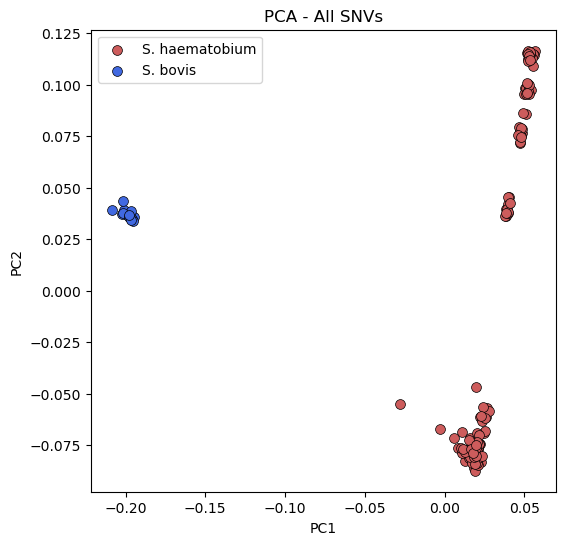

In [254]:
import matplotlib.pyplot as plt
import yaml
import pandas as pd

# Define directories
proj_dir = "/master/nplatt/schisto_aim_panel"
results_dir = f"{proj_dir}/results"

# Load data
info_df = pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",")
all_snvs_df = pd.read_csv(f"{results_dir}/pca/pca_df.csv", sep=",")

# Load YAML config
with open(f"{proj_dir}/code/plotting_config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot for each species
for species in ["S. haematobium", "S. bovis"]:
    all_snv_data = all_snvs_df[all_snvs_df["Predicted Species"] == species]
    ax.scatter(
        all_snv_data["PC1"],
        all_snv_data["PC2"],
        color=config["species"][species]["color"],
        edgecolor="black",
        s=50,
        linewidths=0.5,
        label=species
    )

# Set axis labels, title, and legend
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA - All SNVs")
ax.legend()

# Save the figure
plt.savefig("wg.pca.png", facecolor="white", dpi=600, bbox_inches="tight")
plt.savefig("wg.pca.svg")

# Show plot
plt.show()

# SubSample variants

In [19]:
Path(f"{results_dir}/subsample_snvs").mkdir(parents=True, exist_ok=True)
# Path(f"{results_dir}/fst").mkdir(parents=True, exist_ok=True)

os.chdir(f"{results_dir}/subsample_snvs")

In [20]:
target_n_snvs = (
    list(range(10, 110, 10)) +              # 10–100 by 10
    list(range(200, 1000, 100)) +           # 200–900 by 100
    list(range(1000, 10_000, 1000)) +       # 1000–9000 by 1000
    list(range(10_000, 100_000, 10_000)) +  # 10,000–90,000 by 10,000
    [100_000]                               # Final value
)
target_n_snvs

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70000,
 80000,
 90000,
 100000]

## Subsample from all MAF05 LD variants

In [6]:
import os
import numpy as np
import pandas as pd

# Set project and result directories
proj_dir = "/master/nplatt/schisto_aim_panel"
results_dir = f"{proj_dir}/results"
os.chdir(f"{results_dir}/subsample_snvs")

# Define constants
input_vcf = f"{results_dir}/prep_vcf/scan_autosomes_maf05_ld.vcf"
input_sh_list = f"{results_dir}/prep_vcf/sh.list"
input_sb_list = f"{results_dir}/prep_vcf/sb.list"
input_south_list = f"{results_dir}/prep_vcf/sh_s.list"
input_north_list = f"{results_dir}/prep_vcf/sh_n.list"
output_fst_dir = f"{results_dir}/fst"


all_snvs_df = pd.read_csv(f"{results_dir}/pca/pca.eigenvec.var", sep="\t", header=0)
target_n_snvs = (
    list(range(10, 110, 10)) +              # 10–100 by 10
    list(range(200, 1000, 100)) +           # 200–900 by 100
    list(range(1000, 10_000, 1000)) +       # 1000–9000 by 1000
    list(range(10_000, 100_000, 10_000)) +  # 10,000–90,000 by 10,000
    [100_000]                               # Final value
)
replicates = 100

   
# Loop over target SNV counts and replicates
for n_snvs in target_n_snvs:
    for rep in range(replicates):
        
        # Define filenames
        run_name = f"subsample_n{n_snvs}_rep{rep}"
        output_snv_list = f"{run_name}.list"
        output_vcf = f"{run_name}.vcf"
        output_plink = run_name
        output_stdout = f"{run_name}.stdout"
        output_stderr = f"{run_name}.stderr"
        output_sge = f"{run_name}.sge.sh"

        # Sample SNVs
        random_seed = np.random.randint(0, 9999999)
        sampled_snvs = all_snvs_df["ID"].sample(n=n_snvs, random_state=random_seed)
        sampled_snvs.to_csv(output_snv_list, index=False, header=False)

        # Build SGE shell script
        cmd = f"""#!/bin/bash
#$ -V
#$ -cwd
#$ -S /bin/bash
#$ -q all.q
#$ -pe smp 1
#$ -N {run_name}
#$ -o {output_stdout}
#$ -e {output_stderr}

conda run -n popgen --live-stream --cwd . vcftools --vcf {input_vcf} --snps {output_snv_list} --recode --recode-INFO-all --stdout > {output_vcf}

sleep 5s

conda run -n popgen --live-stream --cwd . plink2 --threads 1 --vcf {output_vcf} --pca 10 --double-id --allow-extra-chr --out {output_plink}
conda run -n popgen --live-stream --cwd . vcftools --weir-fst-pop {input_south_list} --weir-fst-pop {input_north_list} --vcf {output_vcf} --out {output_fst_dir}/south_v_north.{run_name} >{output_fst_dir}/south_v_north.{run_name}.log 2>&1
conda run -n popgen --live-stream --cwd . vcftools --weir-fst-pop {input_south_list} --weir-fst-pop {input_sb_list} --vcf {output_vcf} --out {output_fst_dir}/south_v_sbov.{run_name} >{output_fst_dir}/south_v_sbov.{run_name}.log 2>&1
conda run -n popgen --live-stream --cwd . vcftools --weir-fst-pop {input_north_list} --weir-fst-pop {input_sb_list} --vcf {output_vcf} --out {output_fst_dir}/north_v_sbov.{run_name} >{output_fst_dir}/north_v_sbov.{run_name}.log 2>&1
conda run -n popgen --live-stream --cwd . vcftools --weir-fst-pop {input_sh_list}   --weir-fst-pop {input_sb_list} --vcf {output_vcf} --out {output_fst_dir}/shae_v_sbov.{run_name} >{output_fst_dir}/shae_v_sbov.{run_name}.log 2>&1
conda run -n popgen --live-stream --cwd . vcftools --weir-fst-pop {input_south_list} --weir-fst-pop {input_north_list} --weir-fst-pop {input_sb_list} --vcf {output_vcf} --out {output_fst_dir}/global.{run_name} >{output_fst_dir}/global.{run_name}.log 2>&1     

sleep 5s

"""

        # Write shell script to file
        with open(output_sge, "w") as f:
            f.write(cmd)

        # Submit job
        os.system(f"qsub {output_sge}")


Your job 1488430 ("subsample_n10_rep0") has been submitted
Your job 1488431 ("subsample_n10_rep1") has been submitted
Your job 1488432 ("subsample_n10_rep2") has been submitted
Your job 1488433 ("subsample_n10_rep3") has been submitted
Your job 1488434 ("subsample_n10_rep4") has been submitted
Your job 1488435 ("subsample_n10_rep5") has been submitted
Your job 1488436 ("subsample_n10_rep6") has been submitted
Your job 1488437 ("subsample_n10_rep7") has been submitted
Your job 1488438 ("subsample_n10_rep8") has been submitted
Your job 1488439 ("subsample_n10_rep9") has been submitted
Your job 1488440 ("subsample_n10_rep10") has been submitted
Your job 1488441 ("subsample_n10_rep11") has been submitted
Your job 1488442 ("subsample_n10_rep12") has been submitted
Your job 1488443 ("subsample_n10_rep13") has been submitted
Your job 1488444 ("subsample_n10_rep14") has been submitted
Your job 1488445 ("subsample_n10_rep15") has been submitted
Your job 1488446 ("subsample_n10_rep16") has been 

In [23]:
eigenvec_file

'subsample_n10_rep1.eigenvec'

In [40]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.spatial import procrustes
import glob

# Set environment variables
proj_dir="/master/nplatt/schisto_aim_panel"
results_dir=f"{proj_dir}/results"
os.chdir(f"{results_dir}/subsample_snvs")

target_n_snvs = (
    list(range(10, 110, 10)) +              # 10–100 by 10
    list(range(200, 1000, 100)) +           # 200–900 by 100
    list(range(1000, 10_000, 1000)) +       # 1000–9000 by 1000
    list(range(10_000, 100_000, 10_000)) +  # 10,000–90,000 by 10,000
    [100_000]                               # Final value
)

replicates = 100

procrustes_distances=[]
all_snvs_df = pd.read_csv(f"{results_dir}/pca/pca_df.csv", sep=",")
failed = "failed.pca.log"

with open(failed, 'a') as out:
    out.write(f"n_snvs,rep")
    
    for n_snvs in list(reversed(target_n_snvs)):
        for rep in list(range(0, replicates)):
            try:
                #input
                eigenvec_file = f"subsample_n{n_snvs}_rep{rep}.eigenvec"
                target_pca_df = pd.read_csv(eigenvec_file, sep="\t", header=0)
    
                #output
                png=eigenvec_file.replace("eigenvec", "pca.png")
                svg=png.replace("png", "svg")
                coords_file = eigenvec_file.replace("eigenvec", "transformed_coords.csv")
    
                
                # Extract PC1 and PC2 coordinates from your dataframes
                X = all_snvs_df[["PC1", "PC2"]].to_numpy()
                Y = target_pca_df[["PC1", "PC2"]].to_numpy()
                        
                # Ensure both datasets have the same number of points
                if X.shape != Y.shape:
                    raise ValueError(f"Shapes of X {X.shape} and Y {Y.shape} must be the same for Procrustes analysis.")

                if list(all_snvs_df["IID"]) != list(target_pca_df["IID"]):
                    raise ValueError(f"Samples differ")
                
                # Perform Procrustes analysis
                m1, m2, disparity = procrustes(X, Y)
                
                # Save Procrustes distance
                procrustes_distances.append([n_snvs, rep, disparity])

                # Save PCA + Procrustes aligned coordinates
                out_df = pd.DataFrame({
                    "sample": all_snvs_df["IID"],
                    "wg_pc1": X[:, 0],
                    "wg_pc2": X[:, 1],
                    "panel_pc1": Y[:, 0],
                    "panel_pc2": Y[:, 1],
                    "aligned_wg_pc1": m1[:, 0],
                    "aligned_wg_pc2": m1[:, 1],
                    "aligned_panel_pc1": m2[:, 0],
                    "aligned_panel_pc2": m2[:, 1],
                })
                out_df.to_csv(coords_file, sep=",", index=False, header=True)
                        
                # # Plot the original scatter plots
                # fig, axs = plt.subplots(1, 2, figsize=(12, 5))
                        
                # # # Original Scatter Plots
                # # axs[0].scatter(out_df["wg_pc1"], out_df["wg_pc2"], label=f"WG", color='blue', alpha=0.5, edgecolor="black", linewidth=0.5)
                # # axs[0].scatter(out_df["panel_pc1"], out_df["panel_pc2"], label=f"n={n_snvs}, rep={rep}", color='red', alpha=0.5, edgecolor="black", linewidth=0.5)
                # # axs[0].set_title("Original Scatter Plots")
                # # axs[0].legend()
                        
                # # # Aligned Scatter Plots after Procrustes transformation
                # # axs[1].scatter(out_df["aligned_wg_pc1"], out_df["aligned_wg_pc2"], label=f"WG", color='blue', alpha=0.5, edgecolor="black", linewidth=0.5)
                # # axs[1].scatter(out_df["aligned_panel_pc1"], out_df["aligned_panel_pc2"], label=f"n={n_snvs}, rep={rep}", color='red', alpha=0.5, edgecolor="black", linewidth=0.5)
                # # axs[1].set_title("Procrustes Aligned Scatter Plots")
                # # axs[1].legend()
                        
                # # Save the figure
                # plt.savefig(png, facecolor="white", dpi=600, bbox_inches="tight")
                # plt.savefig(svg)
                # plt.close()
    
            except:
                exit
                with open(failed, 'a') as out:
                    out.write(f"{n_snvs},{rep}\n")
                    
# Convert results to a DataFrame and save
procrustes_df = pd.DataFrame(procrustes_distances, columns=["n_snvs", "replicate", "m2"])
procrustes_df["t0_similarity"] = np.sqrt(1 - procrustes_df["m2"])
procrustes_df.to_csv("procrustes.csv", index=False, header=True, sep=",")

In [41]:
summary = procrustes_df.groupby("n_snvs")["t0_similarity"].agg(
    mean="mean",
    median="median",
    min="min",
    max="max",
    IQR=lambda x: x.quantile(0.75) - x.quantile(0.25),
    n_obs="count"
).reset_index()

summary.to_csv("procrustes.summary.csv", sep=",", header=True, index=False)
summary

,n_snvs,mean,median,min,max,IQR,n_obs
0,10,0.735967,0.764964,0.422477,0.864068,0.143577,41
1,20,0.881892,0.889268,0.738449,0.959196,0.042833,98
2,30,0.922527,0.928840,0.726719,0.972136,0.030340,99
3,40,0.941718,0.942945,0.901090,0.971871,0.018601,100
4,50,0.952686,0.954998,0.921032,0.973650,0.017371,100
5,60,0.958310,0.960746,0.871255,0.978485,0.013340,100
6,70,0.964846,0.965300,0.935893,0.980324,0.009373,100
7,80,0.969117,0.970734,0.935366,0.983184,0.007741,100
8,90,0.972323,0.973273,0.956387,0.985263,0.007685,100
9,100,0.975652,0.976584,0.953938,0.983785,0.004844,100


In [38]:
summary = pd.read_csv("procrustes.summary.csv", sep=",", header=0)
summary["n_obs"].sum()

np.int64(3638)

In [43]:
%%bash

mkdir replicates
mv subsample_n* replicates/

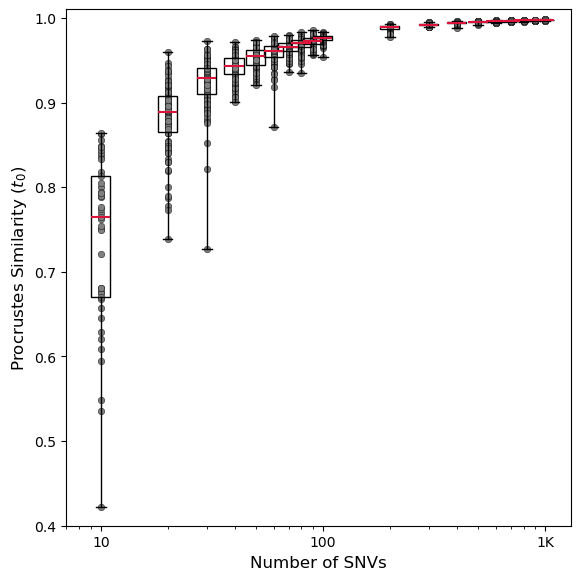

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Filter data
data = procrustes_df.loc[procrustes_df["n_snvs"] >= 10]
snv_values = sorted(data["n_snvs"].unique())

# Grouped data per SNV count
box_data = [data.loc[data["n_snvs"] == n, "t0_similarity"] for n in snv_values]

# Plot setup
cm_to_inch = 0.393701
plt.figure(figsize=(15 * cm_to_inch, 15 * cm_to_inch))

# Boxplot (with no fill)
plt.boxplot(
    box_data,
    positions=snv_values,
    patch_artist=True,
    widths=[n * 0.2 for n in snv_values],
    boxprops=dict(facecolor='none', color='black', zorder=3),
    flierprops=dict(marker='o', markerfacecolor='grey', markeredgecolor='black', markersize=4, linestyle='none'),
    medianprops=dict(color='crimson', linewidth=1.5, zorder=4),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    showfliers=False,
    whis=[0,100]
)

# Overlay jittered points
for i, (n, y_vals) in enumerate(zip(snv_values, box_data)):
    x_vals = np.random.normal(loc=n, scale=n * 0.02, size=len(y_vals))  # jitter on linear x-axis
    x_vals = [n]*len(y_vals)
    plt.scatter(x_vals, y_vals, color='grey', alpha=1, s=22,
                edgecolor='black', linewidth=0.3, zorder=1)

# Log scale and labels
plt.xscale('log')
plt.xticks([10, 100, 1000, 10000, 100000], ["10", "100", "1K", "10K", "100K"])
plt.xlabel("Number of SNVs", fontsize=12)
plt.ylabel(r"Procrustes Similarity ($t_0$)", fontsize=12)
plt.ylim(0.4, 1.01)
plt.xlim(7, 1300)
plt.tight_layout()

# Save and show
plt.savefig("fig1-t0.procrustes.boxplot.alldatapoints.png", dpi=600, bbox_inches="tight", facecolor="white")
plt.savefig("fig1-t0.procrustes.boxplot.alldatapoints.svg", facecolor="white")
data.to_csv("fig1-t0.procrustes.boxplot.alldatapoints.source_data.csv", sep=",", header=True, index=False)
plt.show()


In [24]:
!pwd

/master/nplatt/schisto_aim_panel/results/subsample_snvs


In [45]:
summary = procrustes_df.groupby("n_snvs")["t0_similarity"].agg(
    mean="mean",
    median="median",
    min="min",
    max="max",
    IQR=lambda x: x.quantile(0.75) - x.quantile(0.25),
    n_obs="count"
).reset_index()

summary

,n_snvs,mean,median,min,max,IQR,n_obs
0,10,0.735967,0.764964,0.422477,0.864068,0.143577,41
1,20,0.881892,0.889268,0.738449,0.959196,0.042833,98
2,30,0.922527,0.928840,0.726719,0.972136,0.030340,99
3,40,0.941718,0.942945,0.901090,0.971871,0.018601,100
4,50,0.952686,0.954998,0.921032,0.973650,0.017371,100
5,60,0.958310,0.960746,0.871255,0.978485,0.013340,100
6,70,0.964846,0.965300,0.935893,0.980324,0.009373,100
7,80,0.969117,0.970734,0.935366,0.983184,0.007741,100
8,90,0.972323,0.973273,0.956387,0.985263,0.007685,100
9,100,0.975652,0.976584,0.953938,0.983785,0.004844,100


In [ ]:
pca_n_snvs = [100_000, 10_000, 1_000, 500, 400, 300, 250, 200, 100, 50, 20, 10]

In [56]:
pca_df

,sample,wg_pc1,wg_pc2,panel_pc1,panel_pc2,aligned_wg_pc1,aligned_wg_pc2,aligned_panel_pc1,aligned_panel_pc2
0,NG_au_1.2,-0.198091,0.036822,-0.148371,-0.045152,-0.140928,0.027014,-0.083791,0.013072
1,NG_au_2.10,-0.197004,0.036031,-0.158217,-0.058435,-0.140159,0.026454,-0.090056,0.019457
2,NG_au_2.13,-0.197794,0.036400,-0.148371,-0.045152,-0.140718,0.026715,-0.083791,0.013072
3,NG_au_2.5,-0.197056,0.036287,-0.135617,-0.068853,-0.140196,0.026636,-0.078722,0.026721
4,NG_au_2.6,-0.195994,0.036494,-0.145463,-0.082136,-0.139445,0.026782,-0.084986,0.033106
...,...,...,...,...,...,...,...,...,...
157,niger_libore_166,0.018468,-0.080543,0.030067,-0.017977,0.012223,-0.055987,0.013845,0.011795
158,niger_libore_167,0.019727,-0.080046,-0.029390,0.062106,0.013113,-0.055636,-0.012052,-0.035542
159,niger_libore_168,0.018089,-0.078732,-0.017512,0.031786,0.011955,-0.054706,-0.007945,-0.018411
160,niger_libore_169,0.019798,-0.074796,0.059563,-0.051850,0.013163,-0.051922,0.027127,0.032141


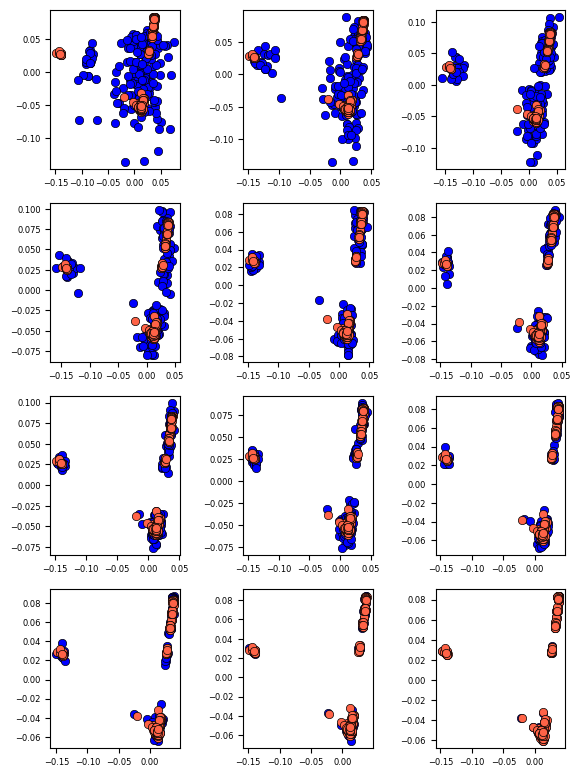

In [119]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Set environment variables
proj_dir = "/master/nplatt/schisto_aim_panel"
results_dir = f"{proj_dir}/results"
os.chdir(f"{results_dir}/subsample_snvs")

# SNV counts to plot, reversed for low-to-high
pca_n_snvs = [10, 20, 50, 100, 200, 300, 400, 500, 1000, 2000, 10000, 100000]

rep = 53  # Or set with np.random.randint(0, 100)

# Set overall figure size
cm_to_inch = 0.393701
fig, axs = plt.subplots(4, 3, figsize=(15 * cm_to_inch, 20 * cm_to_inch))
axs = axs.flatten()

# Collect data records here
records = []

for i, n_snvs in enumerate(pca_n_snvs):
    ax = axs[i]

    coords_file = f"replicates/subsample_n{n_snvs}_rep{rep}.transformed_coords.csv"
    pca_df = pd.read_csv(coords_file, sep=",", header=0)

    wg_x = pca_df["aligned_wg_pc1"]
    wg_y = pca_df["aligned_wg_pc2"]
    p_x = pca_df["aligned_panel_pc1"]
    p_y = pca_df["aligned_panel_pc2"]

    # Plot panel first (underneath)
    ax.scatter(p_x, p_y, label=f"panel SNVs (n={n_snvs:,})", color='blue', alpha=1,
               edgecolor="black", linewidth=0.5, zorder=1)

    # Plot whole-genome on top
    ax.scatter(wg_x, wg_y, label="all SNVs (n=381,501)", color='tomato', alpha=1,
               edgecolor="black", linewidth=0.5, zorder=2)

    ax.tick_params(labelsize=6)
    # ax.legend(fontsize=6, loc='lower left', frameon=True)

    # Collect data into list of records
    for idx, row in pca_df.iterrows():
        records.append({
            "sample": row["sample"],
            "n_snvs": n_snvs,
            "wg_x": row["aligned_wg_pc1"],
            "wg_y": row["aligned_wg_pc2"],
            "p_x": row["aligned_panel_pc1"],
            "p_y": row["aligned_panel_pc2"]
        })

# Hide any unused subplots
for j in range(len(pca_n_snvs), len(axs)):
    axs[j].axis("off")

# Layout and save
plt.tight_layout()
plt.savefig("fig2-pca_procrustes_grid.png", dpi=600, facecolor="white", bbox_inches="tight")
plt.savefig("fig2-pca_procrustes_grid.svg", facecolor="white")
plt.show()

# Save source data to CSV
coords_df = pd.DataFrame.from_records(records)
coords_df = coords_df.rename(columns={
    "wg_x": "aligned_wg_pc1",
    "wg_y": "aligned_wg_pc2",
    "p_x": "aligned_panel_pc1",
    "p_y": "aligned_panel_pc2"
})
coords_df.to_csv("fig2-pca_procrustes_grid.source_data.csv", sep=",", header=True, index=False)

In [18]:
procrustes_df = pd.read_csv("procrustes.csv", header=0, sep=",")
pca_n_snvs = [10, 20, 50, 100, 200, 300, 400, 500, 1000, 2000, 10000, 100000]
rep = 53  # Or set with np.random.randint(0, 100)

fig_to_df = procrustes_df.loc[ ((procrustes_df["replicate"] == rep) & (procrustes_df["n_snvs"].isin(pca_n_snvs)))]
fig_to_df.sort_values(by="n_snvs")

,n_snvs,replicate,m2,t0_similarity
3620,10,53,0.414830,0.764964
3550,20,53,0.208523,0.889650
3253,50,53,0.123753,0.936081
2753,100,53,0.046721,0.976360
2653,200,53,0.025928,0.986951
2553,300,53,0.014600,0.992673
2453,400,53,0.010423,0.994775
2353,500,53,0.012176,0.993893
1853,1000,53,0.004444,0.997776
1753,2000,53,0.003008,0.998495


# Run admixuture

In [50]:
Path(f"{results_dir}/admixture").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/admixture")

In [138]:
rep = 53 
rep_vcfs = glob.glob(f"{results_dir}/subsample_snvs/replicates/subsample_n*_rep{rep}*vcf")

for vcf in rep_vcfs:
    filename = vcf.split("/")[-1]  # get just the filename
    run_name = filename.replace(".vcf", "")
    sge=f"{run_name}.admixture.sge.sh"
    n_snv = int(filename.split("_n")[1].split("_rep")[0])
    
        # Build SGE shell script
    cmd = f"""#!/bin/bash
#$ -V
#$ -cwd
#$ -S /bin/bash
#$ -q all.q
#$ -pe smp 1
#$ -N {run_name}
#$ -o {run_name}.admixture.stdout
#$ -e {run_name}.admixture.stderr

conda run -n plink --cwd . \
    plink \
        --vcf {vcf} \
        --out {run_name} \
        --double-id \
        --recode12 \
        --allow-extra-chr

conda run -n popgen --cwd . --live-stream \
    admixture \
        --cv=1000 \
        -j12 \
        {run_name}.ped \
        2 \
        >{run_name}.admixture.log
        
sleep 5s

"""

    # Write shell script to file
    with open(sge, "w") as f:
        f.write(cmd)
    
    # Submit job
    os.system(f"qsub {sge}")

Your job 1492130 ("subsample_n90_rep53") has been submitted
Your job 1492131 ("subsample_n60000_rep53") has been submitted
Your job 1492132 ("subsample_n400_rep53") has been submitted
Your job 1492133 ("subsample_n60_rep53") has been submitted
Your job 1492134 ("subsample_n6000_rep53") has been submitted
Your job 1492135 ("subsample_n70000_rep53") has been submitted
Your job 1492136 ("subsample_n100_rep53") has been submitted
Your job 1492137 ("subsample_n40_rep53") has been submitted
Your job 1492138 ("subsample_n50000_rep53") has been submitted
Your job 1492139 ("subsample_n2000_rep53") has been submitted
Your job 1492140 ("subsample_n80_rep53") has been submitted
Your job 1492141 ("subsample_n5000_rep53") has been submitted
Your job 1492142 ("subsample_n100000_rep53") has been submitted
Your job 1492143 ("subsample_n90000_rep53") has been submitted
Your job 1492144 ("subsample_n8000_rep53") has been submitted
Your job 1492145 ("subsample_n600_rep53") has been submitted
Your job 1492

In [142]:
%%bash

conda run -n popgen --cwd . bcftools query -l ../subsample_snvs/replicates/subsample_n200_rep53.vcf | head -n -1 >samples.list

In [143]:
# Read in samples
with open("samples.list", 'r') as f:
    samples = f.read().splitlines()

# Get relevant sample info
info_df=pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",", header=0)
info_df.to_csv("sample_info.csv", sep=",", header=True, index=False)

In [314]:
%%bash

conda run -n plink --cwd . \
    plink \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --out scan \
        --double-id \
        --recode12 \
        --allow-extra-chr

PLINK v1.9.0-b.7.7 64-bit (22 Oct 2024)            cog-genomics.org/plink/1.9/
urcell, Christopher Chang   GNU General Public License v3
recode 12 ...".2 flag deprecated.  Use "--
Logging to scan.log.
Options in effect:
  --allow-extra-chr
  --double-id
an--out sc
  --recode 12
  --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf

 515643 MB for main workspace.ving

--vcf: 1k variants complete.
--vcf: 2k variants complete.
variants complete.
--vcf: 4k variants complete.
--vcf: 5k variants complete.
lete.: 6k variants comp
--vcf: 7k variants complete.
--vcf: 8k variants complete.
--vcf: 9k variants complete.
10k variants complete.
--vcf: 11k variants complete.
--vcf: 12k variants complete.
ts complete.arian
--vcf: 14k variants complete.
--vcf: 15k variants complete.
e.vcf: 16k variants complet
--vcf: 17k variants complete.
--vcf: 18k variants complete.
--vcf: 19k variants complete.
20k variants complete.
--vcf: 21k variants complete.
--vcf: 22k variants complete.
ts complete.arian
--vcf: 24k

In [316]:
%%bash

conda run -n popgen --cwd . bcftools query -l ../prep_vcf/scan_autosomes_maf05_ld.vcf | head -n -1 >scan.samples.list

In [317]:
%%bash

conda run -n popgen --cwd . --live-stream \
    admixture \
        --cv=1000 \
        -j12 \
        scan.ped \
        2 \
        >scan.k2.log

In [54]:
rep = 48 
rep_vcfs = glob.glob(f"{results_dir}/subsample_snvs/replicates/subsample_n*_rep{rep}*vcf")

len(rep_vcfs)

37

In [303]:
#read in admixture data to admixture_data{n_snvs}
target_n_snvs = (
    list(range(10, 110, 10)) +              # 10–100 by 10
    list(range(200, 1000, 100)) +           # 200–900 by 100
    list(range(1000, 10_000, 1000)) +       # 1000–9000 by 1000
    list(range(10_000, 100_000, 10_000)) +  # 10,000–90,000 by 10,000
    [100_000]                               # Final value
)

rep = 53

# Read in samples
with open("samples.list", 'r') as f:
    samples = f.read().splitlines()

# Get relevant sample info
rep = 53 
adm_q_files = glob.glob(f"{results_dir}/admixture/subsample_n*_rep{rep}.2.Q")

for file in adm_q_files:
    filename = file.split("/")[-1]  # get just the filename
    run_name = filename.replace(".2.Q", "")
    n_snv = int(filename.split("_n")[1].split("_rep")[0])

    adm_df = pd.read_csv(file, sep=" ", header=None)
    adm_df["sample_name"] = samples

    adm_df = adm_df.merge(info_df, how="left", left_on="sample_name", right_on="Library ID")
    adm_df["n_snvs"] = n_snv
    adm_df = adm_df.rename({0: "0", 1: "1"}, axis=1)
    adm_df = adm_df.sort_values(by=["Predicted Species", "Population Assignment", "Country"]).reset_index(drop=True)

    admixture_data[n_snv] = adm_df[["0", "1", "sample_name", "Predicted Species", "Country", "n_snvs"]]
admixture_data[10]

,0,1,sample_name,Predicted Species,Country,n_snvs
0,0.282704,0.717296,cdivoire_foro_106,S. bovis,Cote d'Ivoire,10
1,0.418576,0.581424,cdivoire_foro_116,S. bovis,Cote d'Ivoire,10
2,0.000010,0.999990,cdivoire_noumousso_107,S. bovis,Cote d'Ivoire,10
3,0.148186,0.851814,cdivoire_noumousso_117,S. bovis,Cote d'Ivoire,10
4,0.435432,0.564568,cdivoire_foro_101,S. bovis,Cote d'Ivoire,10
...,...,...,...,...,...,...
157,0.000010,0.999990,unguja_kinyasini_26,S. haematobium,Zanzibar: Unguja,10
158,0.000010,0.999990,unguja_kinyasini_27,S. haematobium,Zanzibar: Unguja,10
159,0.000010,0.999990,unguja_kinyasini_28,S. haematobium,Zanzibar: Unguja,10
160,0.000010,0.999990,unguja_kinyasini_29,S. haematobium,Zanzibar: Unguja,10


In [328]:
df

,0,1,sample_name,Predicted Species,Country,n_snvs,wg_0,wg_1
0,0.282704,0.717296,cdivoire_foro_106,S. bovis,Cote d'Ivoire,10,0.00001,0.99999
1,0.418576,0.581424,cdivoire_foro_116,S. bovis,Cote d'Ivoire,10,0.00001,0.99999
2,0.000010,0.999990,cdivoire_noumousso_107,S. bovis,Cote d'Ivoire,10,0.00001,0.99999
3,0.148186,0.851814,cdivoire_noumousso_117,S. bovis,Cote d'Ivoire,10,0.00001,0.99999
4,0.435432,0.564568,cdivoire_foro_101,S. bovis,Cote d'Ivoire,10,0.00001,0.99999
...,...,...,...,...,...,...,...,...
157,0.000010,0.999990,unguja_kinyasini_26,S. haematobium,Zanzibar: Unguja,10,0.99999,0.00001
158,0.000010,0.999990,unguja_kinyasini_27,S. haematobium,Zanzibar: Unguja,10,0.99999,0.00001
159,0.000010,0.999990,unguja_kinyasini_28,S. haematobium,Zanzibar: Unguja,10,0.99999,0.00001
160,0.000010,0.999990,unguja_kinyasini_29,S. haematobium,Zanzibar: Unguja,10,0.99999,0.00001


In [331]:
pd.concat([df, df])

,0,1,sample_name,Predicted Species,Country,n_snvs,wg_0,wg_1
0,0.00001,0.99999,cdivoire_foro_106,S. bovis,Cote d'Ivoire,10000,0.00001,0.99999
1,0.00001,0.99999,cdivoire_foro_116,S. bovis,Cote d'Ivoire,10000,0.00001,0.99999
2,0.00001,0.99999,cdivoire_noumousso_107,S. bovis,Cote d'Ivoire,10000,0.00001,0.99999
3,0.00001,0.99999,cdivoire_noumousso_117,S. bovis,Cote d'Ivoire,10000,0.00001,0.99999
4,0.00001,0.99999,cdivoire_foro_101,S. bovis,Cote d'Ivoire,10000,0.00001,0.99999
...,...,...,...,...,...,...,...,...
157,0.99999,0.00001,unguja_kinyasini_26,S. haematobium,Zanzibar: Unguja,10000,0.99999,0.00001
158,0.99999,0.00001,unguja_kinyasini_27,S. haematobium,Zanzibar: Unguja,10000,0.99999,0.00001
159,0.99999,0.00001,unguja_kinyasini_28,S. haematobium,Zanzibar: Unguja,10000,0.99999,0.00001
160,0.99999,0.00001,unguja_kinyasini_29,S. haematobium,Zanzibar: Unguja,10000,0.99999,0.00001


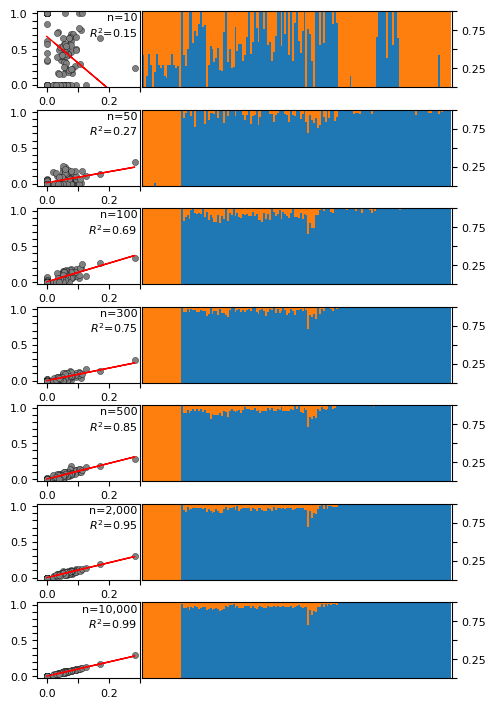

In [375]:
# import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.stats import linregress

all_q_records = []
r2_records = []
scan_df = pd.read_csv(f"scan.2.df.csv", sep=",", header=0)
scan_df = pd.read_csv(f"scan.2.df.csv", sep=",", header=0)
scan_source_df = scan_df[["0", "1", "sample_name", "Country", "Predicted Species"]]
scan_source_df = scan_source_df[["sample_name", "Predicted Species", "Country", "0", "1"]]
scan_source_df = scan_source_df.rename({"0": "All q0",
                  "1": "All q1",
                  "sample_name": "Sample ID",
                  "n_snvs": "Panel size"
                 }, axis=1)

scan_source_df["Panel size"] = "all"
scan_source_df["Panel q0"] = scan_source_df["All q0"]
scan_source_df["Panel q1"] = scan_source_df["All q1"]

source_df=pd.DataFrame()

scan_df = scan_df.sort_values(by=["Predicted Species", "Population Assignment", "Country"]).reset_index(drop=True)
scan_df = scan_df[["0", "1", "Library ID"]].rename({"0": "wg_0", "1": "wg_1", "Library ID": "sample_name"}, axis=1)

# Convert mm to inches
mm_to_inch = 1 / 25.4
fig_width_mm = 170
fig_height_mm = 220

# SNV values to loop over
pca_n_snvs = [10, 50, 100, 300, 500, 2_000, 10_000]

# Set up figure and grid layout
fig = plt.figure(figsize=(fig_width_mm * mm_to_inch, fig_height_mm * mm_to_inch))
gs = gridspec.GridSpec(nrows=len(pca_n_snvs), ncols=5, figure=fig, wspace=0.02, hspace=0.3)

for row_i, n_snvs in enumerate(pca_n_snvs):
    df = admixture_data[n_snvs]

    df = df.merge(scan_df, how="left", left_on="sample_name", right_on="sample_name")

    # --- Column 0: Scatter plot for S. haematobium only ---
    ax1 = fig.add_subplot(gs[row_i, 0])
    df_sh = df.loc[df["Predicted Species"] == "S. haematobium"]
    scan_q = scan_df.loc[df["Predicted Species"] == "S. haematobium", "wg_1"]
    panel_q = df_sh["1"]

    # Scatter
    ax1.scatter(scan_q, panel_q, color='gray', alpha=1, s=20,
                edgecolor="black", linewidth=0.25)

    # Linear regression and line
    slope, intercept, r_value, p_value, std_err = linregress(scan_q, panel_q)
    reg_line = slope * scan_q + intercept
    ax1.plot(scan_q, reg_line, color='red', linewidth=1, alpha=1, zorder=1)

    # Annotate R²
    ax1.text(0.98, 0.98, f"n={n_snvs:,}\n$R^2$={r_value**2:.2f}", transform=ax1.transAxes,
             fontsize=8, verticalalignment='top', horizontalalignment='right')

    # Axis formatting
    # Set ticks at every 0.1
    ticks = np.arange(0.0, 1.01, 0.1)
    
    # Only label every other tick (even-indexed ones)
    tick_labels = [f"{t:.1f}" if i % 2 == 0 else "" for i, t in enumerate(ticks)]
    
    # Ticks every 0.1
    ticks = np.arange(0.0, 1.01, 0.1)
    
    # X-axis: label every other tick
    x_tick_labels = [f"{t:.1f}" if i % 2 == 0 else "" for i, t in enumerate(ticks)]
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(x_tick_labels, fontsize=6)
    
    # Y-axis: label only 0.0, 0.5, 1.0
    y_tick_labels = [f"{t:.1f}" if t in [0.0, 0.5, 1.0] else "" for t in ticks]
    ax1.set_yticks(ticks)
    ax1.set_yticklabels(y_tick_labels, fontsize=6)
    ax1.tick_params(labelsize=8)

    ax1.set_xlim(-0.03, 0.3)
    ax1.set_ylim(-0.03, 1.03)
    
    # --- Columns 1–3: Admixture stacked barplot (K=2) ---
    ax2 = fig.add_subplot(gs[row_i, 1:4])
    x = np.arange(len(df))
    bottom = np.zeros(len(df))
    for k in ["0", "1"]:
        ax2.bar(x, df[k], bottom=bottom, edgecolor="none", width=1.0)
        bottom += df[k]

    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, len(df))
    ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax2.set_yticklabels(["", "0.25", "", "0.75", ""], fontsize=8)
    # Move y-axis ticks and labels to the right side
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right')

    ax2.set_xticks([])
    # ax2.set_yticks([])
    # if row_i == 0:
    #     ax2.set_title(f"Admixture (n={n_snvs:,})", fontsize=10)
    # if row_i == len(pca_n_snvs) // 2:
    #     ax2.set_ylabel("Ancestry", fontsize=8)

    # Save R²
    r2_records.append({
        "n_snvs": n_snvs,
        "r2": r_value ** 2
    })
    source_df = pd.concat([source_df, df])
    
# # Save or show
# # plt.tight_layout()
# plt.savefig("fig3-admixture_panel_comparison.png", dpi=600, bbox_inches="tight", facecolor="white")
# plt.savefig("fig3-admixture_panel_comparison.svg", bbox_inches="tight", facecolor="white")
# plt.savefig("fig3-admixture_panel_comparison.tiff", dpi=600, bbox_inches="tight", facecolor="white")

# Create and save q-values DataFrame
source_df = source_df.rename({"0": "Panel q0", 
                  "1": "Panel q1", 
                  "wg_0": "All q0",
                  "wg_1": "All q1",
                  "sample_name": "Sample ID",
                  "n_snvs": "Panel size"
                 }, axis=1)

source_df = source_df[['Sample ID', 'Predicted Species', 'Country', 'Panel size', 'Panel q0', 'Panel q1', 'All q0', 'All q1']]
source_df = pd.concat([source_df, scan_source_df]).reset_index(drop=True)
source_df.to_csv("fig3-admixture_panel_comparison.qvalues.sourcedata.csv", index=False)

# # Create and save R² summary DataFrame
r2_df = pd.DataFrame(r2_records)
r2_df.to_csv("fig3-admixture_panel_comparison.r2.sourcedatacsv", index=False)
plt.show()


In [394]:
df.loc[df["Predicted Species"] == "S. haematobium"]

,0,1,sample_name,Predicted Species,Country,n_snvs
21,0.999990,0.000010,cameroon_SRR13579883,S. haematobium,Cameroon,10
22,0.429588,0.570412,cdivoire_raviart_108,S. haematobium,Cote d'Ivoire,10
23,0.284210,0.715790,cdivoire_raviart_109,S. haematobium,Cote d'Ivoire,10
24,0.508357,0.491643,ivorycoast_SRR13579866,S. haematobium,Cote d'Ivoire,10
25,0.999990,0.000010,cdivoire_kongobo_115,S. haematobium,Cote d'Ivoire,10
...,...,...,...,...,...,...
157,0.000010,0.999990,unguja_kinyasini_26,S. haematobium,Zanzibar: Unguja,10
158,0.000010,0.999990,unguja_kinyasini_27,S. haematobium,Zanzibar: Unguja,10
159,0.000010,0.999990,unguja_kinyasini_28,S. haematobium,Zanzibar: Unguja,10
160,0.000010,0.999990,unguja_kinyasini_29,S. haematobium,Zanzibar: Unguja,10


In [396]:

r2_records = []


# Set environment variables
proj_dir="/master/nplatt/schisto_aim_panel"
results_dir=f"{proj_dir}/results"
os.chdir(f"{results_dir}/admixture")
scan_df = pd.read_csv("scan.2.df.csv", sep=",", header=0)

target_n_snvs = (
    list(range(10, 110, 10)) +              # 10–100 by 10
    list(range(200, 1000, 100)) +           # 200–900 by 100
    list(range(1000, 10_000, 1000)) +       # 1000–9000 by 1000
    list(range(10_000, 100_000, 10_000)) +  # 10,000–90,000 by 10,000
    [100_000]                               # Final value
)

rep = 53

all_snvs_df = pd.read_csv(f"{results_dir}/pca/pca_df.csv", sep=",")

with open("linear_regression.data.csv", 'w') as out:
    out.write(f"n_snvs,rep,slope.r2,slope.slope,slope.intercept,slope.p_value,slope.std_err,skew.skew,skew.mean,skew.med,skew.min,skew.max,skew.std_err")
    
    for row_i, n_snvs in enumerate(target_n_snvs):
        df = admixture_data[n_snvs] 
        
        df_sh = df.loc[df["Predicted Species"] == "S. haematobium"]
        scan_q = scan_df.loc[scan_df["Predicted Species"] == "S. haematobium", "1"]
        panel_q = df_sh["1"]
    
        # Linear regression
        slope, intercept, r_value, p_value, std_err = linregress(scan_q, panel_q)
    
        #residuals
        residuals = scan_q - panel_q

        bias_skew = float(skew(residuals))
        bias_mean = float((residuals).mean())
        bias_med  = float((residuals).median())
        bias_min = float(residuals.min())
        bias_max = float(residuals.max())
        bias_serr = float(np.std(residuals))/ np.sqrt(len(residuals))

        # Save R²
        r2_records.append({
            "n_snvs": n_snvs,
            "rep": rep,
            "r2": r_value ** 2,
            "slope": slope,
            "intercept": intercept,
            "p_value": p_value,
            "std_err": std_err,
            "skew": bias_skew,
            "skew.mean": bias_mean,
            "skew.med": bias_med,
            "skew.min": bias_min,
            "skew.max": bias_max,
            "skew.ste": bias_serr
        })


# Create and save R² summary DataFrame
r2_df = pd.DataFrame(r2_records)
r2_df.to_csv("linear_regression.data.csv", index=False)
plt.show()


In [49]:
r2_df = pd.read_csv("linear_regression.data.csv", header=0, sep=",")
r2_df

,n_snvs,rep,r2,slope,intercept,p_value,std_err,skew,skew.mean,skew.med,skew.min,skew.max,skew.ste
0,10,53,0.153155,-3.668941,0.679248,1.598872e-06,0.731761,-0.003677,-0.496298,-0.481443,-0.999980,0.127546,0.034944
1,20,53,0.318106,1.476442,0.008792,3.275823e-13,0.183350,-1.952624,-0.027461,0.000000,-0.450340,0.095446,0.007885
2,30,53,0.536050,-4.644207,0.866183,6.055391e-25,0.366469,0.049693,-0.645018,-0.593333,-0.999980,-0.107891,0.025321
3,40,53,0.252568,0.610490,0.005848,2.152834e-10,0.089078,-0.633566,0.009415,0.000000,-0.160177,0.104625,0.003990
4,50,53,0.271922,0.769712,0.010244,3.356630e-11,0.106829,-0.806174,-0.001220,0.000000,-0.189957,0.104625,0.004561
5,60,53,0.543849,1.501562,0.015089,1.851156e-25,0.116641,-1.145510,-0.034742,0.000000,-0.232179,0.070448,0.005214
6,70,53,0.425265,1.085900,0.012605,1.969149e-18,0.107075,-1.348972,-0.015971,0.000000,-0.288641,0.127546,0.004507
7,80,53,0.375664,0.659937,0.001133,6.589791e-16,0.072161,0.141717,0.012193,0.000000,-0.098003,0.127546,0.003264
8,90,53,0.454914,0.609539,-0.002528,4.801940e-20,0.056593,0.251731,0.017828,0.000000,-0.081979,0.104236,0.002754
9,100,53,0.691024,1.296052,0.003231,2.872798e-37,0.073507,-0.660810,-0.014832,0.000000,-0.142785,0.073500,0.003262


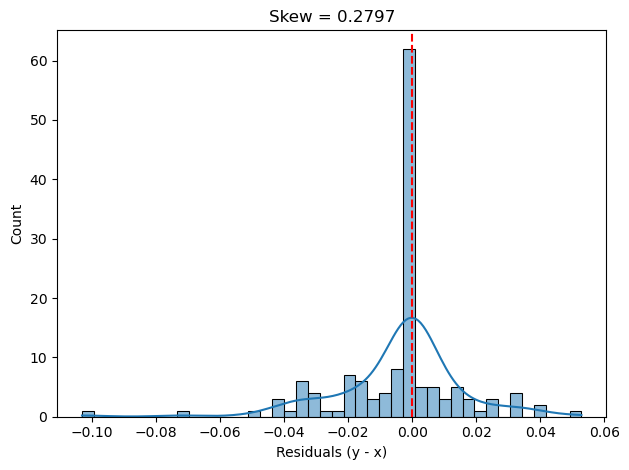

In [401]:
import matplotlib.pyplot as plt
import seaborn as sns

df = admixture_data[500] 

df_sh = df.loc[df["Predicted Species"] == "S. haematobium"]
scan_q = scan_df.loc[scan_df["Predicted Species"] == "S. haematobium", "1"]
panel_q = df_sh["1"]

residuals = scan_q - panel_q

sns.histplot(residuals, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residuals (y - x)")
plt.title(f"Skew = {residual_skew:.4f}")
plt.tight_layout()
plt.show()


# Fst

In [34]:
Path(f"{results_dir}/fst").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/fst")

In [37]:
vcfs = glob.glob(f"{results_dir}/subsample_snvs/replicates/subsample_n*_rep*vcf")

for vcf in vcfs:
    filename = vcf.split("/")[-1]  # get just the filename
    run_name = filename.replace(".vcf", "")
    sge=f"{run_name}.fst.sge.sh"
    n_snv = int(run_name.split("_n")[1].split("_rep")[0])
    rep=int(run_name.split("_n")[1].split("_")[1].replace("rep", ""))
    
    cmd = f"""#!/bin/bash
# Build SGE shell script
#!/bin/bash
#$ -V
#$ -cwd
#$ -S /bin/bash
#$ -q all.q
#$ -pe smp 1
#$ -N {run_name}.global_fst
#$ -o {run_name}.global_fst.stdout
#$ -e {run_name}.global_fst.stderr

conda run -n popgen --live-stream --cwd . \
    vcftools \
        --weir-fst-pop ../prep_vcf/sb.list \
        --weir-fst-pop ../prep_vcf/sh_n.list \
        --weir-fst-pop ../prep_vcf/sh_s.list \
        --vcf {vcf} \
        --out {run_name}.per_site_global
       
sleep 1s
"""

    # Write shell script to file
    with open(sge, "w") as f:
        f.write(cmd)
    
    # Submit job
    os.system(f"qsub {sge}")

Your job 1544268 ("subsample_n100000_rep33.global_fst") has been submitted
Your job 1544269 ("subsample_n30_rep36.global_fst") has been submitted
Your job 1544270 ("subsample_n90000_rep66.global_fst") has been submitted
Your job 1544271 ("subsample_n400_rep76.global_fst") has been submitted
Your job 1544272 ("subsample_n3000_rep23.global_fst") has been submitted
Your job 1544273 ("subsample_n1000_rep81.global_fst") has been submitted
Your job 1544274 ("subsample_n10_rep30.global_fst") has been submitted
Your job 1544275 ("subsample_n2000_rep57.global_fst") has been submitted
Your job 1544276 ("subsample_n3000_rep47.global_fst") has been submitted
Your job 1544277 ("subsample_n40000_rep72.global_fst") has been submitted
Your job 1544278 ("subsample_n500_rep76.global_fst") has been submitted
Your job 1544279 ("subsample_n90_rep80.global_fst") has been submitted
Your job 1544280 ("subsample_n600_rep84.global_fst") has been submitted
Your job 1544281 ("subsample_n30_rep93.global_fst") has 

In [42]:
%%bash

#get all of the fst values into a single csv to be imported to a df
echo "n_snvs,rep,fst">fsts.csv
grep "Weir and Cockerham weighted Fst estimate:" *stderr | cut -f1,3 -d":" | sed 's/.global_fst.stderr: /,/' | sed 's/subsample_n//' | sed 's/_rep/,/' >>fsts.csv


In [43]:
fst_df = pd.read_csv("fsts.csv", sep=",", header=0)
fst_df

,n_snvs,rep,fst
0,100000,0,0.42872
1,100000,10,0.42937
2,100000,11,0.42922
3,100000,12,0.43005
4,100000,13,0.42925
...,...,...,...
3695,90,96,0.46887
3696,90,97,0.38564
3697,90,98,0.40183
3698,90,99,0.48213


In [46]:
import pandas as pd
import numpy as np
from scipy.stats import iqr

# Group by n_snvs
grouped = fst_df.groupby("n_snvs")["fst"]

# Create a summary dataframe
summary_df = grouped.agg(
    mean="mean",
    median="median",
    min="min",
    max="max",
    stdev="std",
    count="count"
).reset_index()

# Calculate IQR and standard error
summary_df["IQR"] = grouped.apply(iqr).values
summary_df["stderr"] = (summary_df["stdev"] / np.sqrt(summary_df["count"]))

summary_df = summary_df[["n_snvs", "mean", "median", "min", "max", "IQR", "stderr", "stdev", "count"]]
summary_df.to_csv("fst.summary.csv")
summary_df

,n_snvs,mean,median,min,max,IQR,stderr,stdev,count
0,10,0.411006,0.409845,0.14760,0.66138,0.162403,0.010919,0.109187,100
1,20,0.426506,0.435020,0.28692,0.60576,0.081908,0.006305,0.063045,100
2,30,0.420251,0.428500,0.29732,0.55830,0.062565,0.005278,0.052784,100
3,40,0.433744,0.438310,0.31728,0.55276,0.068568,0.005055,0.050553,100
4,50,0.424555,0.421505,0.30874,0.52943,0.052965,0.004426,0.044263,100
5,60,0.426272,0.429260,0.33391,0.49788,0.040785,0.003554,0.035540,100
6,70,0.432475,0.433935,0.34969,0.52122,0.053120,0.003607,0.036073,100
7,80,0.426837,0.426635,0.33284,0.52872,0.044302,0.003382,0.033816,100
8,90,0.427542,0.425690,0.34219,0.51176,0.042442,0.003279,0.032789,100
9,100,0.427116,0.425835,0.35854,0.52950,0.040335,0.003380,0.033800,100


In [172]:
%%bash

#get fst from the full dataset
conda run -n popgen --live-stream --cwd . \
    vcftools \
        --weir-fst-pop ../prep_vcf/sh_n.list \
        --weir-fst-pop ../prep_vcf/sh_s.list \
        --weir-fst-pop ../prep_vcf/sb.list \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--weir-fst-pop ../prep_vcf/sh_n.list
f/sh_s.list-pop ../prep_vc
	--weir-fst-pop ../prep_vcf/sb.list
	--keep ../prep_vcf/sh_n.list
_s.list ../prep_vcf/sh
	--keep ../prep_vcf/sb.list

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Flo

<Figure size 334.646x354.331 with 0 Axes>

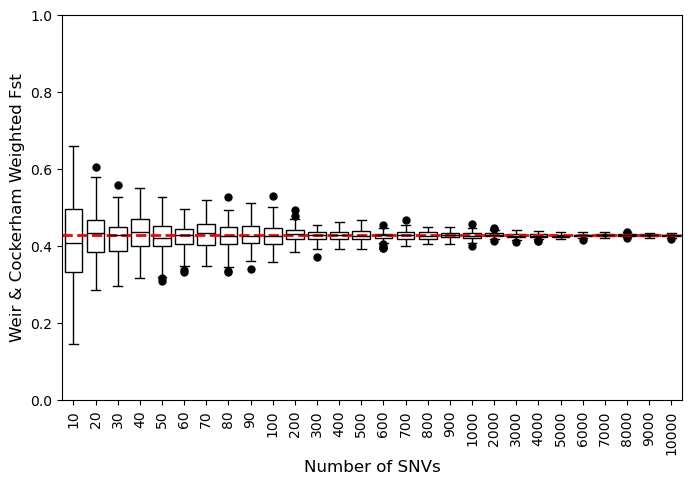

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns


# Convert mm to inches
mm_to_inch = 1 / 25.4

# Create a boxplot grouped by 'n_snvs' using 'fst' as values
fig = plt.figure(figsize=(85 * mm_to_inch, 90 * mm_to_inch))
plt.figure(figsize=(8, 5))
sns.boxplot(x="n_snvs", 
            y="fst", 
            data=fst_df,
            zorder=2, 
            color = "white", 
            linewidth=1, 
            linecolor="black", 
            flierprops=dict(marker='o', markerfacecolor='black', markeredgecolor='black', markersize=5, linewidth=0.01)
           )

# Add horizontal line at 0.80617
plt.axhline(y=0.42886, color='red', linestyle='--', linewidth=2, zorder=2)

#set ylims
plt.ylim(0, 1)
plt.xlim(-0.5, 27.5)


# Set labels and title
plt.xlabel("Number of SNVs", fontsize=12)
plt.xticks(rotation=90)
plt.ylabel("Weir & Cockerham Weighted Fst", fontsize=12)

# Save the figure
plt.savefig("fig4-global_fst_box.png", dpi=600, bbox_inches="tight", facecolor="white")
plt.savefig("fig4-global_fst_box.svg", bbox_inches="tight", facecolor="white")
plt.savefig("fig4-global_fst_box.tiff", dpi=600, bbox_inches="tight", facecolor="white")
fst_df.to_csv("fig4-global_fst.png.sourcedata.csv", index=False)

# Show the plot
plt.show()

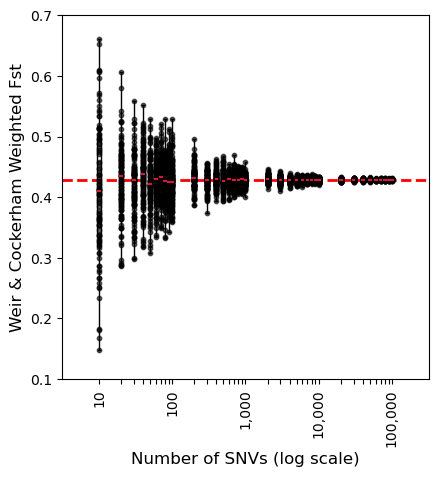

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Unique n_snvs values and their log positions
snv_values = sorted(fst_df["n_snvs"].unique())
log_positions = np.log10(snv_values)

# Prepare box data
box_data = [fst_df.loc[fst_df["n_snvs"] == snv, "fst"].values for snv in snv_values]

# Convert mm to inches
mm_to_inch = 1 / 25.4
fig, ax = plt.subplots(figsize=(120 * mm_to_inch, 120 * mm_to_inch))

# Plot boxplots at log positions
ax.boxplot(
    box_data,
    positions=log_positions,
    patch_artist=True,
    widths=0.05,  # Constant width in log space
    boxprops=dict(facecolor='none', color='black', zorder=3),
    flierprops=dict(marker='o', markerfacecolor='grey', markeredgecolor='black', markersize=4, linestyle='none'),
    medianprops=dict(color='crimson', linewidth=1.5, zorder=4),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    showfliers=False,
    whis=[0, 100]
)

# Add individual data points at log positions
for i, snv in enumerate(snv_values):
    y_vals = box_data[i]
    x_vals = np.full_like(y_vals, log_positions[i])
    ax.scatter(x_vals, y_vals, color='black', alpha=0.6, s=10, zorder=2)

# Horizontal line
ax.axhline(y=0.42886, color='red', linestyle='--', linewidth=2, zorder=1)

# All SNV values (tick positions)
snv_values = sorted(fst_df["n_snvs"].unique())
log_positions = np.log10(snv_values)

# Ticks to label
label_snvs = [10, 100, 1_000, 10_000, 100_000]
label_positions = np.log10(label_snvs)

# Plot the boxplot as before (this part stays unchanged)
# ...

# Set all ticks, but only label a subset
ax.set_xticks(log_positions)
ax.set_xticklabels(
    [f"{v:,}" if v in label_snvs else "" for v in snv_values],
    rotation=90
)
ax.set_xlabel("Number of SNVs (log scale)", fontsize=12)
# Y-axis
ax.set_ylabel("Weir & Cockerham Weighted Fst", fontsize=12)
ax.set_ylim(0.1, 0.7)

# Save
plt.savefig("fig4-global_fst.log_x.png", dpi=600, bbox_inches="tight", facecolor="white")
plt.savefig("fig4-global_fst.log_x.svg", bbox_inches="tight", facecolor="white")
plt.savefig("fig4-global_fst.log_x.tiff", dpi=600, bbox_inches="tight", facecolor="white")
fst_df.to_csv("fig4-global_fst.log_x.sourcedata.csv", index=False)

plt.show()


# Fake primers for cost estimate

In [5]:
Path(f"{results_dir}/primer_cost_estimate").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/primer_cost_estimate")

In [8]:
import random

def random_dna_sequence(length):
    return ''.join(random.choices("ACGT", k=length))

# Rows A–H and columns 1–12
rows = "ABCDEFGH"
cols = range(1, 13)

output_lines = []

for row in rows:
    for col in cols:
        well = f"{row}{col}"
        for i in range(1, 3):  # Two primers per well
            length = random.randint(18, 25)
            name = f"Primer{i}_{well}"
            seq = random_dna_sequence(length)
            output_lines.append(f"{well},{name},{seq}")

# Write to file
with open("primers_96well.csv", "w") as f:
    f.write("Well Position,Sequence Name,Sequence\n")
    f.write('\n'.join(output_lines))

In [10]:
!cat primers_96well.csv

Well Position,Sequence Name,Sequence
A1,Primer1_A1,AGTTCGAGACCCGATTACAAAACA
A1,Primer2_A1,CTTACTCGCCATTCTGTA
A2,Primer1_A2,CTTTCAATCGTCTACTTAACCCT
A2,Primer2_A2,TATCGACCCTGAGTGCGACAGA
A3,Primer1_A3,GATTCGCTGTTTACGACTAAAA
A3,Primer2_A3,CATCATTTGATTGTAAAG
A4,Primer1_A4,CCCCGTGCGTAATACCGTG
A4,Primer2_A4,TGAAACGCAGCATCCTTGACGT
A5,Primer1_A5,CACTGCATACGGTCGCTA
A5,Primer2_A5,ACCGTAGTCCAGGGCACG
A6,Primer1_A6,TGCGACAGAGGACGTGAC
A6,Primer2_A6,GCGCGCTCACCTTGTAGTGAGTCCG
A7,Primer1_A7,AGGCCTATTTTAGATGCCGAG
A7,Primer2_A7,CATTTGTTACATCCAGCTT
A8,Primer1_A8,GACAAGTGCTCTTCATATGGATAG
A8,Primer2_A8,GCAATGAGGTCACCCGCA
A9,Primer1_A9,GCCCCGAAGATTAATCGCC
A9,Primer2_A9,CACCTCGGGCATAGTATAGGAACT
A10,Primer1_A10,AATTGATGGCAGCCATGCTGTATT
A10,Primer2_A10,ATCTGCCACGAGTTTGTGTTA
A11,Primer1_A11,GGATATGAAGATAGAACACCGAATC
A11,Primer2_A11,TTTCGCCACGGGTAATTCATGA
A12,Primer1_A12,TGAACTAGTATCCAACCTTACGTT
A12,Primer2_A12,ACAAGCATTTGCCCTTATTCAGT
B1,Primer1_B1,TAGTACCCTCACCCTGGTT
B1,Primer2_B1,GAGCATGCGAAACTAAATAA
B2,Primer1_